In [ ]:
# default_exp gen

In [ ]:
#export
import numpy as np
import matplotlib.pyplot as plt
import svgwrite
import shapely
from shapely.geometry import LineString, Point
from  functools import partial
from box_generator.lineprims import *
from nbdev import *

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
# Basic Line functions

In [ ]:
#export
class Side:
    def __init__(self, line, height, min_tab_size, thick):
        line = OneLine(line)
        self.base = line
        self.x_dir = line.ax
        self.y_dir = line.ay
        self.height = height
        self.min_tab_size=min_tab_size
        self.thick=thick
        self.is_inner=False
        self.mx, self.my=0,0 # information about movement
        
        self.l = OneLine([line[0],line[1], line[0],line[1] ])
        self.l[2+line.ay] += height
        self.r = OneLine([line[2], line[3], line[2], line[3]])
        self.r[2+line.ay] += height
        self.t =OneLine([self.l[2], self.l[3], self.r[2], self.r[3]])
        self.result = None
    
        
    def generate_bottomside(self):
        bottom = LineObj.generate_tabs(self.base, self.min_tab_size, self.thick)
        top = LineObj.generate_tabs(self.t, self.min_tab_size, -self.thick)
        left = LineObj.generate_tabs(self.l, self.min_tab_size, self.thick)
        right = LineObj.generate_tabs(self.r, self.min_tab_size, -self.thick)
        self.result = np.vstack([bottom.lines, 
                                 top.lines,
                                 left.lines,
                                 right.lines])
    
    def generate_outer_wall(self):  
        holes = LineObj.generate_holes(self.base, self.min_tab_size, self.thick, comp=False)
        holes.move_in_ay(self.thick)  
        d = 1 if self.x_dir==0 else -1
        left = LineObj.generate_tabs(self.l, self.min_tab_size, d*self.thick, comp=False)
        right = LineObj.generate_tabs(self.r, self.min_tab_size, -d*self.thick, comp=False)
        top = self.t.copy()
        base = self.base.copy()
        if self.x_dir:
            right.move_in_ay(-self.thick)
            left.move_in_ay( self.thick)
        else:
            top += [self.thick, 0, -self.thick,0]
            base +=[self.thick, 0, -self.thick,0]
        self.result = np.vstack([holes.lines, 
                                 left.lines,
                                 right.lines, 
                                 top, 
                                 base])
        
    def add_holes(self, line):
        line = OneLine(line)
        line.move_xy(self.mx, self.my)
        holes = LineObj.generate_holes(line, self.min_tab_size, self.thick, comp=True)
        self.result = np.vstack([self.result, holes.lines])
        
    def generate_inner_wall(self):
        # this one is a bit tricy since the floor has an offset to the rest of the walls.
        # we first generate the sides as usual but then move the top base and top line
        # and also need to trim the end of the lines
        self.is_inner=True
        tabs1 = LineObj.generate_tabs(self.base, self.min_tab_size, self.thick, comp=True)
        tabs1.move_in_ay(self.thick)
        tabs2 = LineObj.generate_tabs(self.l, self.min_tab_size, self.thick, comp=False)
        tabs2[0, self.y_dir] += self.thick*2
        tabs2[-1, self.y_dir+2] += self.thick
        
        tabs3 = LineObj.generate_tabs(self.r, self.min_tab_size, -self.thick, comp=False)
        tabs3[0, self.y_dir] += self.thick*2
        tabs3[-1, self.y_dir+2] += self.thick
        
        top = OneLine(self.t)
        top.move_in_ay(self.thick)        
        self.result = np.vstack([tabs1.lines, tabs2.lines, tabs3.lines,top ])
        
    def flip_h(self):
        self.result[:,[0,2]] = -self.result[:,[0,2]] + np.max(self.result[:,[0,2]])
        
    def flip_v(self):
        self.result[:,[1,3]] = -self.result[:,[1,3]] + np.max(self.result[:,[1,3]])
        
    def move(self, x, y):
        self.mx +=x
        self.my +=y
        self.result += [x,y,x,y]
        
    def plot_outline(self):
        lines = np.array([self.base, self.l, self.r, self.t])
        plot_lines(lines)
        
    def plot(self):
        plot_lines(self.result)
        
    def add_inner_walls(self,other_side):
        if other_side.x_dir == self.x_dir:
            #lines are paralell, we don't make any more comparisons
            return  # they do not intersect
        myline = LineString(np.array(self.base).reshape(2,2))
        oline = LineString(np.array(other_side.base).reshape(2,2))
        pint = myline.intersection(oline)
        try:
            p = pint.x, pint.y
            i_line = OneLine([p[0],
                      p[1],
                      p[0],
                      p[1]])
            i_line[self.y_dir] = 0
            i_line[self.y_dir+2] = self.height
          
        except:
            # we didn't find any intersection
            return 
        
        ps = self.base.reshape(2,2)
        any(np.isclose(ps,p).sum(axis=1)==2)
        if any(np.isclose(ps,p).sum(axis=1)==2):
            # return if intersection is our own endpoint
            return
        print(f"intersection point: {p}, line {other_side.base}")
        ps = other_side.base.reshape(2,2)
        any(np.isclose(ps,p).sum(axis=1)==2)
        if any(np.isclose(ps,p).sum(axis=1)==2):
            print("endpoint found")
            # Endpoint, we shoud generate holes in our self
            holes = LineObj.generate_holes(i_line, self.min_tab_size, self.thick, comp=True)
            if self.is_inner:
                holes.move_in_ax(-self.thick) # todo, check if I'm an inner wall.
            x = np.min(self.result[:,[0,2]])
            y = np.min(self.result[:,[1,3]])
            holes.move_xy(x,y)
            self.result =np.vstack([self.result, holes.lines])
        else:
            print('intersection found')
            i_line.move_in_ax(self.thick)
            l1, l2 = i_line.copy(), i_line.copy()
            # split the lines
            l1.move_in_ay(-self.thick/2)
            l2.move_in_ay(self.thick/2)
            x =np.min(self.result[:,[0,2]])
            y =np.min(self.result[:,[1,3]])
            l1.move_xy(x,y)
            l2.move_xy(x,y)

            if i_line.ax==1:
                dim = 0
                d= -1
            else:
                dim = 2
                d = 1
            half = self.height/2
            l1[self.y_dir+dim] -=d*half
            l2[self.y_dir+dim] -=d*half
            l1[[self.x_dir, self.x_dir+2]]
            l2[[self.x_dir, self.x_dir+2]]
            x = np.min(self.result[:,[0,2]])
            y = np.min(self.result[:,[1,3]])

            if self.x_dir==1:
                print('x')
                print(dim)
                l1.move_xy(-self.thick,0)
                l2.move_xy(-self.thick,0)
                l3 = OneLine([l1[self.y_dir+dim],
                      l1[self.x_dir+dim],
                      l2[self.y_dir+dim],
                      l2[self.x_dir+dim]])
            else:
                print('y')
                print(dim)
                l1.move_in_ax(half)
                l2.move_in_ax(half)
                #l1.move_xy(0, -self.thick)
                #l2.move_xy(0, -self.thick)
                dim=0
                l3 = OneLine([l1[self.x_dir+dim],
                      l1[self.y_dir+dim],
                      l2[self.x_dir+dim],
                      l2[self.y_dir+dim]])
            print(l1, l2, l3)
            slitz = np.vstack([l1, l2, l3])
            #slitz += [self.mx, self.my, self.mx, self.my]
            self.result =np.vstack([self.result, slitz])

In [ ]:
line1 = OneLine([0,0, 0,200])
c1 = line1.copy()
c2 = line1.copy()

In [ ]:
c1[0] +=10
c1, c2

(l: [ 10.   0.   0. 200.], ax: 1, l: [  0.   0.   0. 200.], ax: 1)

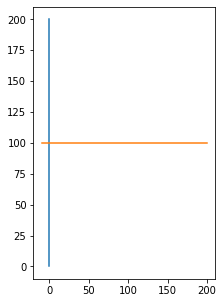

In [ ]:
line1 = OneLine([0,0, 0,200])
line2 = OneLine([-10, 100, 200, 100])
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
line1.plot()
line2.plot()
tab_sz =15
th = 5
s1 = Side(line1, 50,tab_sz, th)
s2 = Side(line2, 50, tab_sz, th)

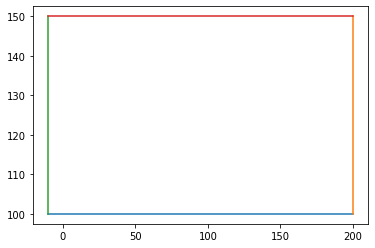

In [ ]:
s2.base.plot()
s2.r.plot()
s2.l.plot()
s2.t.plot()

intersection point: (0.0, 100.0), line [-10. 100. 200. 100.]
intersection found
x
2
[ 5.  97.5 30.  97.5] [  5.  102.5  30.  102.5] [ 30.   97.5  30.  102.5]
intersection point: (100.0, 0.0), line [100. -10. 100. 200.]
intersection found
y
2
[102.5  30.  102.5  55. ] [107.5  30.  107.5  55. ] [102.5  30.  107.5  30. ]


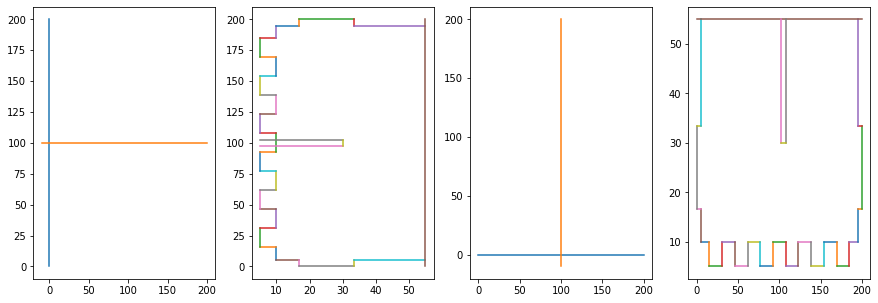

In [ ]:
line1 = OneLine([0,0, 0,200])
line2 = OneLine([-10, 100, 200, 100])
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
line1.plot()
line2.plot()
tab_sz =15
th = 5
s1 = Side(line1, 50,tab_sz, th)
s2 = Side(line2, 50, tab_sz, th)

s1.generate_inner_wall()
#s1.move(45,70)
s1.add_inner_walls(s2)
plt.subplot(1,4,2)
s1.plot()

line1 = np.array([0,0, 200,0])
line2 = np.array([100, -10, 100, 200])
plt.subplot(1,4,3)
plot_lines(np.array([line1, line2]))

s1 = Side(line1, 50,tab_sz, th)
s2 = Side(line2, 50, tab_sz, th)

s1.generate_inner_wall()
#s1.move(-20,50)
s1.add_inner_walls(s2)
plt.subplot(1,4,4)
s1.plot()

intersection point: (0.0, 100.0), line [  0. 100. 200. 100.]
endpoint found


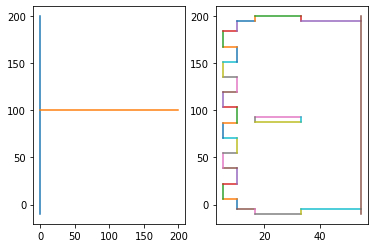

In [ ]:
line1 = np.array([0,-10, 0,200])
line2 = np.array([0, 100, 200, 100])
plt.figure()
plt.subplot(1,2,1)
plot_lines(np.array([line1, line2]))

s1 = Side(line1, 50,15,5)
s2 = Side(line2, 50,15, 5)

s1.generate_inner_wall()
s1.add_inner_walls(s2)
plt.subplot(1,2,2)
s1.plot()


# Inner walls + Holes example

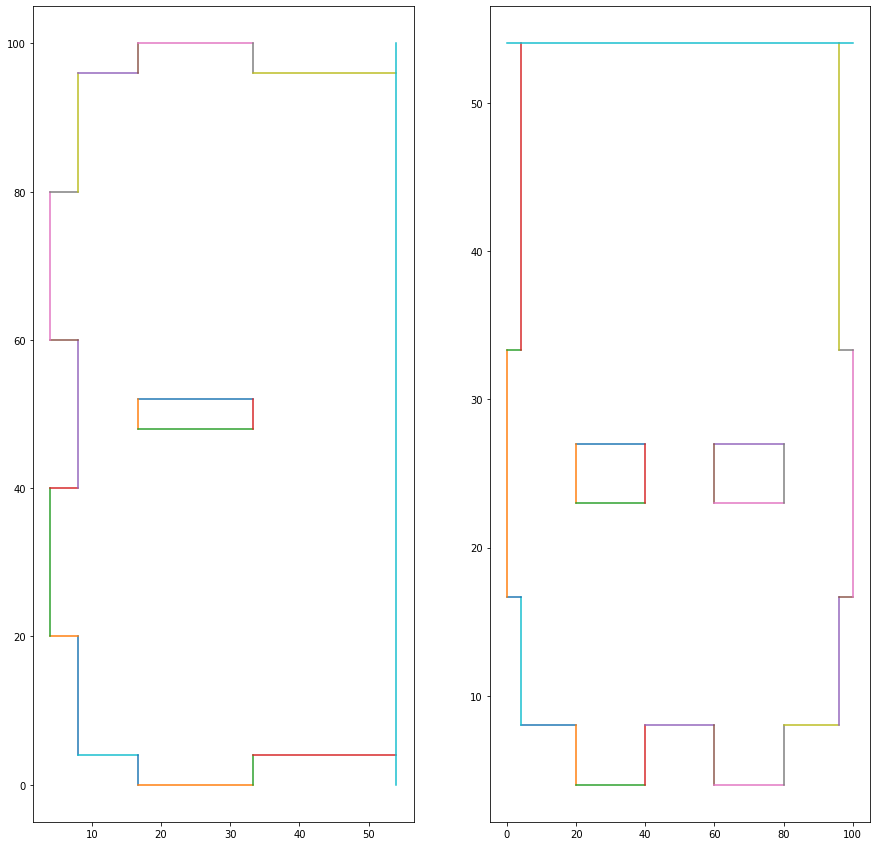

In [ ]:

l = [0,0, 0, 100]
line = [0,50, 50,50]
s = Side(l, 50, min_tab_size=15, thick=4)
s.generate_inner_wall()
s.add_holes(line)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
s.plot()

l = [0,0, 100, 0]
line = [0,25, 100,25]
s = Side(l, 50,min_tab_size=15, thick=4 )
s.generate_inner_wall()
s.add_holes(line)
plt.subplot(1,2,2)
s.plot()

# Outer walls example

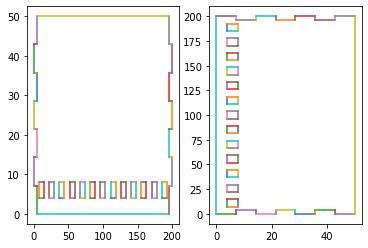

In [ ]:
l = [0, 0, 200, 0]
s = Side(l, 50,7,4)
s.generate_outer_wall()
plt.subplot(1,2,1)
s.plot()

l = [0, 0, 0, 200]
s = Side(l, 50,7,4)
s.generate_outer_wall()
plt.subplot(1,2,2)
s.plot()

# Bottom Side example

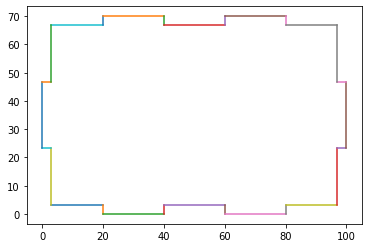

In [ ]:
l = [0,0,100,0]
tab_size = 20
thick = 3
s = Side(l, 70, tab_size, thick)
s.generate_bottomside()
s.plot()

# Box Generator

In [ ]:
#export
def gen_points(x, y):
    return [0,0], [0, y], [x, y ], [x, 0]

class BoxGen:
    def __init__(self, 
                 playwood_thickness,
                x_size_mm, y_size_mm,
                height_mm,
                min_tabsize_mm=30):
        self.thickness = playwood_thickness
        self.x = x_size_mm
        self.y = y_size_mm
        self.height = height_mm
        self.min_tabsize = min_tabsize_mm
        bottom_line = [0,0, x_size_mm, 0 ]
        self.bottom = Side(bottom_line, y_size_mm, min_tabsize_mm, playwood_thickness)
        self.bottom.generate_bottomside()
        
        lr_line = [0,0,0, y_size_mm]
        left =  Side(lr_line, height_mm, min_tabsize_mm, playwood_thickness)
        left.generate_outer_wall()
        left.move(-height_mm, 0)
        
        right =  Side(lr_line, height_mm, min_tabsize_mm, playwood_thickness)
        right.generate_outer_wall()
        right.move(-height_mm*2,0)
        
        
        ul_line = [0,0,x_size_mm, 0]
        upper =  Side(ul_line, height_mm,min_tabsize_mm, playwood_thickness)
        upper.generate_outer_wall()
        upper.move(0,-height_mm)
        
        lower = Side(ul_line, height_mm,min_tabsize_mm, playwood_thickness)
        lower.generate_outer_wall()
        lower.move(0,-height_mm*2)
        
        self.outer_walls = [left, right, upper, lower]
        self.inner_walls = list()
        
    
    def plot_outline(self):
        p1,p2,p3,p4 =gen_points(self.x, self.y)
        lines = np.array([p1 + p2, p2+p3, p3+p4, p4+p1])
        plot_lines(lines)
        for s in self.inner_walls:
            plot_lines([s.base])

        
    def add_innerwall(self, p1,p2):
        line = OneLine(p1+p2)
        iwall = Side(line, self.height,self.min_tabsize, self.thickness)
        iwall.generate_inner_wall()
        
        self.bottom.add_holes(line)

        num = len([s for s in self.inner_walls if s.x_dir==iwall.x_dir])
        #else:
        x_start = np.min(iwall.result[:,0])
        y_start = np.min(iwall.result[:,1])
        x,y = -x_start, -y_start        ## hur många
        if iwall.x_dir==0:
            y+= num*self.height + self.y
        else:
            x+= num *self.height + self.x
        
        print(x,y)
            
        iwall.move(x,y)
        self.inner_walls.append(iwall)
        for owall in self.outer_walls:
            owall.add_inner_walls(iwall)
            
    def update_inner_walls(self):
        for s1 in self.inner_walls:
            for s2 in self.inner_walls:
                if s1 is s2:
                    continue
                else:
                    print(s1.base, s2.base)
                    s1.add_inner_walls(s2)
        
    def plot(self):
        self.bottom.plot()
        for i, s in enumerate(self.outer_walls):
            s.plot()
            
        for s in self.inner_walls:
            s.plot()
    
    @staticmethod
    def to_dwg(obj, dwg):
        for r in obj.result:
            dwg.add(dwg.line((r[0]*mm,r[1]*mm),(r[2]*mm,r[3]*mm), stroke="#000"))
        
    def export_to_svg(self, filename):
        dwg = svgwrite.Drawing(filename, profile='tiny')
        func1 = partial(self.to_dwg, dwg=dwg)
        func1(self.bottom)
        list(map(func1, self.outer_walls))
        list(map(func1, self.inner_walls))
        dwg.save()

In [ ]:
box = BoxGen(playwood_thickness=3.2,
                x_size_mm=150, 
                y_size_mm=100,
                height_mm=50,
                min_tabsize_mm=10)

box.add_innerwall((50,30), (50,100))
box.add_innerwall((100,0), (100,100))
box.add_innerwall((0,30), (150,30))


96.8 -30.0
96.8 -0.0
intersection point: (100.0, 0.0), line [100.   0. 100. 100.]
endpoint found
intersection point: (100.0, 0.0), line [100.   0. 100. 100.]
endpoint found
-0.0 66.8
intersection point: (0.0, 30.0), line [  0.  30. 150.  30.]
endpoint found
intersection point: (0.0, 30.0), line [  0.  30. 150.  30.]
endpoint found


[ 50.  30.  50. 100.] [100.   0. 100. 100.]
[ 50.  30.  50. 100.] [  0.  30. 150.  30.]
[100.   0. 100. 100.] [ 50.  30.  50. 100.]
[100.   0. 100. 100.] [  0.  30. 150.  30.]
intersection point: (100.0, 30.0), line [  0.  30. 150.  30.]
intersection found
x
2
[200.   28.4 225.   28.4] [200.   31.6 225.   31.6] [225.   28.4 225.   31.6]
[  0.  30. 150.  30.] [ 50.  30.  50. 100.]
intersection point: (50.0, 30.0), line [ 50.  30.  50. 100.]
endpoint found
[  0.  30. 150.  30.] [100.   0. 100. 100.]
intersection point: (100.0, 30.0), line [100.   0. 100. 100.]
intersection found
y
2
[101.6 125.  101.6 150. ] [104.8 125.  104.8 150. ] [101.6 125.  104.8 125. ]


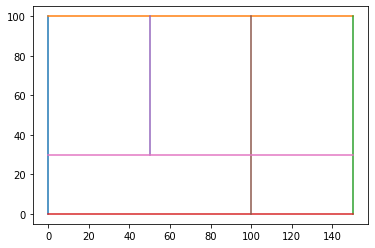

In [ ]:
box.update_inner_walls()
box.plot_outline()

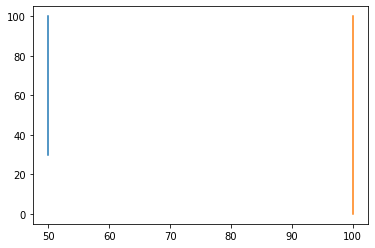

In [ ]:
plot_lines([box.inner_walls[0].base,
box.inner_walls[1].base])

In [ ]:
# När man skapar innerväggen behöver den flytta sig.

In [ ]:
# todo, när man lägger till innerväggar blir håler förskjutna på ytterväggarna.

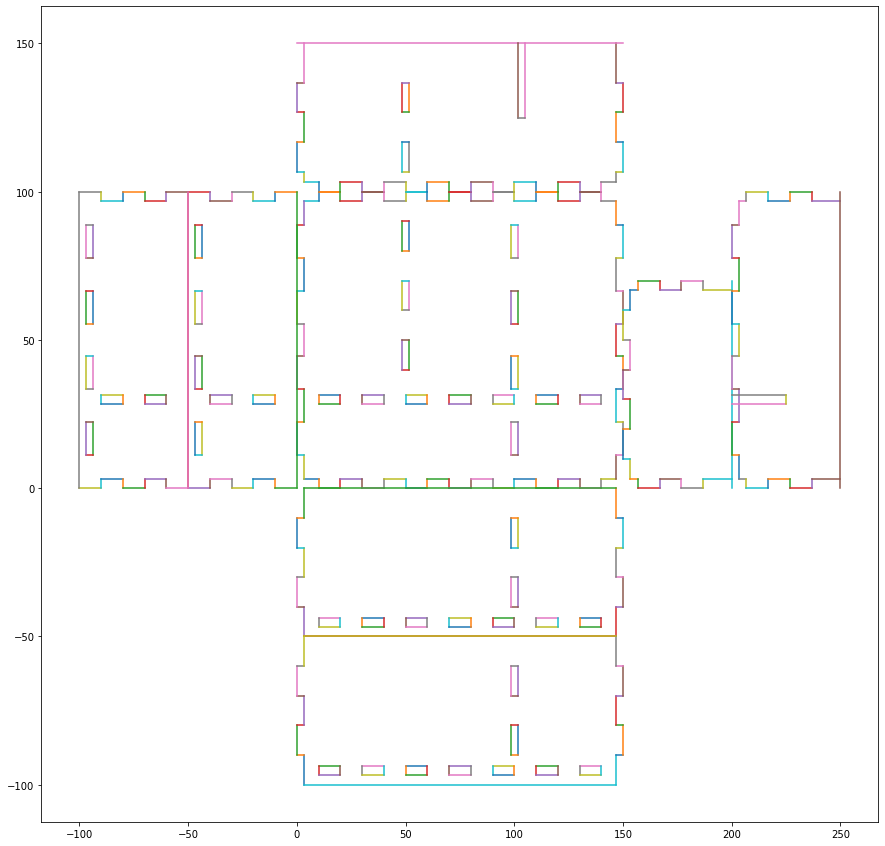

In [ ]:
plt.figure(figsize=(15,15))
box.plot()

In [ ]:
# changing this one too to see if it also need to be chan